# Proceso **ETL** orientado a un modelo de Análisis de Sentimiento (Español)

## 1-. El Dataset




El ***DataSet*** utilizado para el proceso es un conjunto de datos (*0000.parquet*) de reseñas de productos de Amazon en español, disponible en la plataforma Hugging Face para tareas de procesamiento de lenguaje natural como clasificación, generación de texto o análisis de sentimiento.

<https://huggingface.co/datasets/KRadim/edit_amazon_reviews_multi_es>

Este dataset forma parte de una colección mayor conocida como Multilingual Amazon Reviews (corpus multilingüe de reseñas de Amazon), la cual fue desarrollada originalmente con datos balanceados de reseñas en múltiples idiomas y estrellas de evaluación para facilitar tareas de aprendizaje automático.

## 2-. Contenido y estructura del dataset


El dataset incluye:
1.  Reseñas en español

    Cada registro contiene texto de reseña en español.

2.  Campos principales por registro

    Los atributos que contiene cada fila son:
    - id: Identificador único de la reseña.
    - stars: Calificación numérica del producto (de 1 a 5 estrellas).
    - review_body: Texto completo de la reseña del producto.
    - review_title: Título o resumen corto de la reseña.
    - language: Código de idioma (en este caso siempre “es” para español).
    - product_category: Categoría o tipo de producto (por ejemplo “electronics”, “home”, etc.).
    - lenght_review_body: Longitud (número de caracteres) del cuerpo de la reseña.
    - lenght_review_title: Longitud del título.
    - lenght_product_category: Longitud del nombre de la categoría del producto.
Para nuestro caso, nos enfocaremos en la columna "review_body".

## 3-. Librerias

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## 4-. Extracción de archivos (Extract)
En esta fase obtenemos los datos desde su fuente original. Se cargar la información sin modificarla, preservando la evidencia original.

In [3]:
df = pd.read_parquet('0000.parquet')

In [4]:
df.head(3)

,id,stars,review_body,review_title,language,product_category,lenght_review_body,lenght_review_title,lenght_product_category
0,111516,1,No llegaron las hélices,Mal servicio,es,electronics,23,12,11
1,107084,4,Me encanta lo ligera y manejable que es. Plega...,Manejable y ligera,es,baby_product,420,18,12
2,199386,1,"De las dos baterias , hay una que no funciona",No comprare mas,es,home_improvement,45,15,16


### 4.1-. Validaciones iniciales

Aqui vemos las columnas que existen, texto del comentario, las etiquetas y el tamaño del DataSet.

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 199500 entries, 0 to 199499
Data columns (total 9 columns):
 #   Column                   Non-Null Count   Dtype 
---  ------                   --------------   ----- 
 0   id                       199500 non-null  uint32
 1   stars                    199500 non-null  int64 
 2   review_body              199500 non-null  object
 3   review_title             199500 non-null  object
 4   language                 199500 non-null  object
 5   product_category         199500 non-null  object
 6   lenght_review_body       199500 non-null  uint32
 7   lenght_review_title      199500 non-null  uint32
 8   lenght_product_category  199500 non-null  uint32
dtypes: int64(1), object(4), uint32(4)
memory usage: 10.7+ MB


In [7]:
df.shape

(199500, 9)

In [8]:
df['lenght_review_body'].describe()

,lenght_review_body
count,199500.000000
mean,151.289950
std,132.185062
min,16.000000
25%,68.000000
50%,120.000000
75%,186.000000
max,3086.000000


## 5-. Trasformación

Aquí se limpia, normaliza y estructura el texto para que el modelo pueda aprender patrones reales.

La transformación se divide en sub-etapas lógicas.

1.   Selección de columnas relevantes
2.   Eliminación de nulos
3.   Normalización de idioma
4.   Eliminación de comentarios duplicados
5.   Limpieza de texto (Text Cleaning)
6.   Creación de la etiqueta de sentimiento (Labeling)
7.   Balanceo y validación de clases
8.   Análisis estadístico para tomar un subconjunto de datos del DataSet (5000), para el entrenamiento del modelo.



In [9]:
df.head(3)

,id,stars,review_body,review_title,language,product_category,lenght_review_body,lenght_review_title,lenght_product_category
0,111516,1,No llegaron las hélices,Mal servicio,es,electronics,23,12,11
1,107084,4,Me encanta lo ligera y manejable que es. Plega...,Manejable y ligera,es,baby_product,420,18,12
2,199386,1,"De las dos baterias , hay una que no funciona",No comprare mas,es,home_improvement,45,15,16


### 5.1-. Selección de columnas relevantes

Eliminar ruido mejora rendimiento y reduce sesgo.

In [10]:
df = df[['id','review_body', 'stars', 'language','lenght_review_body']]

### 5.2-. Eliminación de elementos nulos

Un comentario vacío no aporta información semántica.
Es un método de pandas que sirve para eliminar valores nulos (`NaN, None, NaT`) del DataFrame.

Quá hace por defecto:

- Elimina filas.

- Elimina la fila completa si encuentra al menos un valor nulo (esto se puede controlar con parámetros).

`subset=['review_body']` Este parámetro indica en qué columna(s) se debe verificar la existencia de valores nulos.

En este caso:

- Solo se revisa la columna review_body.

- Si review_body es NaN en una fila, esa fila se elimina.

- Los valores nulos en otras columnas no afectan la eliminación.

Es necesario por que los valores nulos en columnas de texto:

- Provocan errores al tokenizar

- Dañan el entrenamiento del modelo

- Generan resultados inconsistentes

In [11]:
df = df.dropna(subset=['review_body'])

### 5.3-. Normalización de idioma

Normalización es el proceso de transformar datos válidos pero heterogéneos en una representación uniforme y consistente para facilitar su análisis, comparación y modelado.

Los modelos deben entrenarse en un solo idioma ('es' en nuestro caso).

`df['language'].str` -> Es el accesor de pandas para operaciones vectorizadas sobre strings.
Permite aplicar métodos de texto a toda la columna, sin usar bucles.

`df['language'].str.lower()` -> Convierte todo el texto de la columna a minúsculas. ("ES" → "es", "En-US" → "en-us")

`df['language'].str.lower().str[:2]` -> Extrae solo los primeros 2 caracteres de cada valor de la columna ("es" → "es", "es-es" → "es" o "english" → "en"). Esto es clave porque los códigos de idioma *ISO 639-1* usan 2 letras (es, en, fr, etc.).

`df['language'] == 'es'` -> Crea una condición booleana:

- True para filas cuyo idioma es español ('es')

- False para el resto

Se reasigna el DataFrame:

- df ahora contiene únicamente registros en español

- Se descartan comentarios en otros idiomas

In [12]:
df['language'] = df['language'].str.lower().str[:2]
df = df[df['language'] == 'es']

### 5.4-. Eliminación de comentarios duplicados

Los comentarios duplicados sesgan el modelo, haciéndolo aprender frases específicas en lugar de patrones generales.

- `df['review_body'].str.lower()` ->  Convierte todo el texto de la columna a minúsculas.
- `df['review_body'].str.lower().str.strip()` -> Elimina espacios en blanco al inicio y al final del texto.

El texto ya normalizado se guarda en una nueva columna `'review_body_clean'`, preservando el texto original sin modificar.

- Permite trazabilidad

- Facilita auditoría

- Evita pérdida de información

`df.drop_duplicates(...)` -> Método de pandas para eliminar filas duplicadas.

`subset=['review_body_clean']` -> Indica que la comparación de duplicados se hace solo sobre la columna `review_body_clean`.


In [13]:
df['review_body_clean'] = (
    df['review_body']
    .str.lower()
    .str.strip()
)
df = df.drop_duplicates(subset=['review_body_clean'])

In [14]:
df.head(3)

,id,review_body,stars,language,lenght_review_body,review_body_clean
0,111516,No llegaron las hélices,1,es,23,no llegaron las hélices
1,107084,Me encanta lo ligera y manejable que es. Plega...,4,es,420,me encanta lo ligera y manejable que es. plega...
2,199386,"De las dos baterias , hay una que no funciona",1,es,45,"de las dos baterias , hay una que no funciona"


### 5.5-. Limpieza de texto (Text Cleaning)

El texto crudo puede contiener: mayúsculas, símbolos, números saltos de línea, etc. Todo esto debe estandarizarce.

También debemos remover la puntuación en los comentarios. Normalmente se eliminan:
- .,;:!?¿¡
- Comillas
- Paréntesis
- Símbolos especiales

`df['review_body'].str.lower()` -> Convierte a minusculas todo los comentarios.

`.str.replace(r'http\S+', '', regex=True)` -> Elimina URLs.

`.str.replace(r'[^a-záéíóúñü\s]', '', regex=True)` ->
- ^ → negar, no reemplazar ^a-záéíóúñü\s → solo admite letras en español.

`.str.replace(r'\s+', ' ', regex=True)` -> Elimina espacios multiples.

In [15]:
df['review_body_clean'] = (
    df['review_body']
    .str.lower()
    .str.replace(r'http\S+', '', regex=True)
    .str.replace(r'[^a-záéíóúñü\s]', '', regex=True)
    .str.replace(r'\s+', ' ', regex=True)
    .str.strip()
)

df = df.drop_duplicates(subset=['review_body_clean'])

## 5.6-. Analisis de longitud de comenatios

In [16]:
df["review_length_words"] = (
    df["review_body_clean"]
    .astype(str)
    .str.split()
    .str.len()
)

In [17]:
df.head(3)

,id,review_body,stars,language,lenght_review_body,review_body_clean,review_length_words
0,111516,No llegaron las hélices,1,es,23,no llegaron las hélices,4
1,107084,Me encanta lo ligera y manejable que es. Plega...,4,es,420,me encanta lo ligera y manejable que es plegad...,86
2,199386,"De las dos baterias , hay una que no funciona",1,es,45,de las dos baterias hay una que no funciona,9


In [18]:
df['review_length_words'].max()

551

<Axes: >

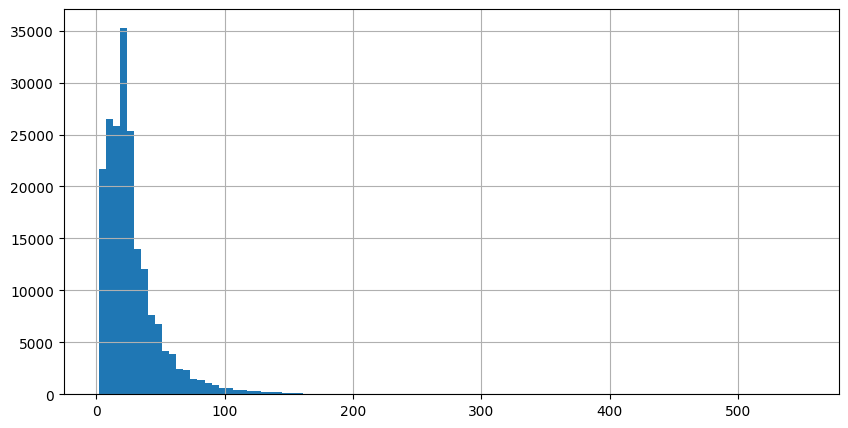

In [19]:
df["review_length_words"].hist(bins=100, figsize=(10, 5))

In [20]:
df[df["review_length_words"] == 0].head(20)
df.sort_values("review_length_words", ascending=False).head(20)

,id,review_body,stars,language,lenght_review_body,review_body_clean,review_length_words
87137,106299,"Hago estos cambios en mi opinión, no por el pr...",5,es,3086,hago estos cambios en mi opinión no por el pro...,551
2949,69222,Compré esta depiladora recomendada por una ami...,2,es,2898,compré esta depiladora recomendada por una ami...,495
104323,128410,La idea de este producto está bastante bien: m...,2,es,2727,la idea de este producto está bastante bien ma...,470
130048,47054,"La linterna funciona muy bien, en términos gen...",3,es,2459,la linterna funciona muy bien en términos gene...,453
194864,156188,La idea era comprar un radio reloj despertador...,5,es,2392,la idea era comprar un radio reloj despertador...,417
177477,108025,Encontré estos cascos por 15 euros. .. y lo ci...,1,es,2356,encontré estos cascos por euros y lo cierto es...,399
22128,54918,Estaba cansado de tener muchos cuchillos y que...,5,es,2206,estaba cansado de tener muchos cuchillos y que...,395
188362,13590,El producto no esta mal en cuanto a sonido y f...,1,es,2023,el producto no esta mal en cuanto a sonido y f...,387
34389,104362,"Lo cierto es que funcionar, funciona, pero de ...",4,es,1981,lo cierto es que funcionar funciona pero de un...,383
49116,128552,"La cámara en general está muy bien, en compara...",4,es,2201,la cámara en general está muy bien en comparac...,380


### 5.6-. Creación de la etiqueta de sentimiento (Labeling)

Labeling es el proceso de asignar una clase objetivo (sentimiento) a cada observación, basándose en una fuente confiable, para permitir el entrenamiento de modelos supervisados.

Ejemplo usando estrellas:

- 1-2 → Negativo
- 3 → Neutro
- 4–5 → Positivo

In [23]:
def sentimiento(stars):
    if stars <= 2:
        return "negativo"
    elif stars == 3:
        return "neutro"
    else:
        return "positivo"

df['sentiment'] = df['stars'].apply(sentimiento)

### 5.7-. Balanceo y validación de clases

La validación de clases consiste en verificar la distribución de tu variable objetivo (sentiment) antes de entrenar el modelo.

Objetivo:

- Confirmar que todas las clases existen

- Ver si alguna clase domina a las demás

- Detectar posibles sesgos

Sin esta validación, puedes entrenar un modelo aparentemente bueno, pero inútil en la práctica.

Un dataset desbalanceado provoca modelos sesgados.

In [24]:
df['sentiment'].value_counts(normalize=True)

,proportion
sentiment,
negativo,0.401935
positivo,0.397514
neutro,0.200551


No es un dataset perfectamente uniforme, pero está dentro de un rango saludable.

Regla práctica:

- Clases principales ~40/40 → excelente

- Clase neutra ~20 → aceptable y usable

### 5.8-. Análisis estadístico para tomar subconjuntos de datos del DataSet (500, 1000 y 5000), para el entrenamiento del modelo.

Variación de la longitud de los caracteres de los comentarios.

In [25]:
def Histograma(dataframe, xlabel, ylabel, title, bin = 150):
  plt.hist(dataframe, bins=bin, color='skyblue', edgecolor='black')
  plt.xlabel(xlabel)
  plt.ylabel(ylabel)
  plt.title(title)
  return plt.show()

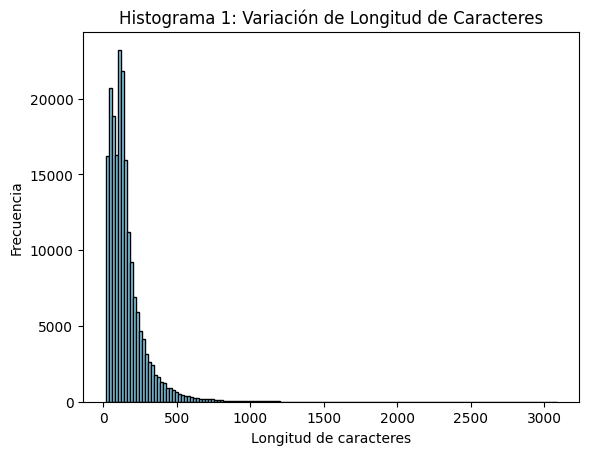

In [26]:
Histograma(df['lenght_review_body'], 'Longitud de caracteres', 'Frecuencia', 'Histograma 1: Variación de Longitud de Caracteres')

Notamos que la función de distribución presenta una acumulación al rededor de la media de 152.4 para la longitud de los comentarios ('*lenght_review_body*'), esto lo debemos tener en cuenta para tomar una muestra aleatoria de los 5000 datos.

Teniendo en cuenta el resultado anterior no podemos usar **Muestreo aleatorio simple** (como habíamos considerado anteriormente)
```
df.sample(n=5000, random_state=42)
```
Ya que puede presentar sesgos:
- Puede romper la proporción de clases
- Puede sub-representar:
  - sentimiento negativo
  - neutro (normalmente minoritario)
- Introduce variabilidad entre ejecuciones

El **Muestreo estratificado** conserva la distribución original de la variable objetivo (sentiment).
- Mantiene proporciones
- Evita sesgo
- Es reproducible

Esta función crea un subconjunto del DataFrame de tamaño aproximado n, manteniendo la proporción original de clases en la columna sentiment.

`df.groupby('sentiment', group_keys=False)` -> Agrupa el DataFrame por la columna sentiment. Esto crea grupos independientes:

- Un grupo para positivo
- Un grupo para negativo
- Un grupo para neutro

`group_keys=False` evita que sentiment se agregue como índice extra al resultado final.

`.apply(lambda x: ...)` -> Aplica una función a cada grupo.

Aquí:
- x es un sub-DataFrame que contiene solo una clase
- La función se ejecuta de forma independiente por clase

`int(len(x) / len(df) * n)` -> Calcula cuántos registros tomar de esa clase para el nuevo dataset.

In [28]:
def DataSets(df, n):
    return (
        df
        .groupby('sentiment', group_keys=False)
        .apply(
            lambda x: x.sample(
                n=int(len(x) / len(df) * n),
                random_state=42
            )
        )
    )

In [31]:
df_500 = DataSets(df,500)
df_1000 = DataSets(df,1000)
df_5000 = DataSets(df,5000)
df_40000 = DataSets(df,40000)
df_completo = df

/tmp/ipython-input-586521533.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(
/tmp/ipython-input-586521533.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(
/tmp/ipython-input-586521533.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation.

In [32]:
df_40000.info()

<class 'pandas.core.frame.DataFrame'>
Index: 39999 entries, 191723 to 53294
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   id                   39999 non-null  uint32
 1   review_body          39999 non-null  object
 2   stars                39999 non-null  int64 
 3   language             39999 non-null  object
 4   lenght_review_body   39999 non-null  uint32
 5   review_body_clean    39999 non-null  object
 6   review_length_words  39999 non-null  int64 
 7   sentiment            39999 non-null  object
dtypes: int64(2), object(4), uint32(2)
memory usage: 2.4+ MB


Guardando los DataSets, considerando solo lsa columnas 'id' y 'review_body_clean'.

In [34]:
df_500_fx = df_500[['id','review_body','stars','language','lenght_review_body','review_body_clean','sentiment']]
df_1000_fx = df_1000[['id','review_body','stars','language','lenght_review_body','review_body_clean','sentiment']]
df_5000_fx = df_5000[['id','review_body','stars','language','lenght_review_body','review_body_clean','sentiment']]
df_40000_fx = df_40000[['id','review_body','stars','language','lenght_review_body','review_body_clean','sentiment']]
df_completo_fx = df_completo[['id','review_body','stars','language','lenght_review_body','review_body_clean','sentiment']]

Ordenamos los datos segun su 'id'.

In [35]:
df_500_fx.sort_values(by='id', inplace=True, ignore_index= True)
df_1000_fx.sort_values(by='id', inplace=True, ignore_index= True)
df_5000_fx.sort_values(by='id', inplace=True, ignore_index= True)
df_40000_fx.sort_values(by='id', inplace=True, ignore_index= True)
df_completo_fx.sort_values(by='id', inplace=True, ignore_index= True)

/tmp/ipython-input-100851429.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_500_fx.sort_values(by='id', inplace=True, ignore_index= True)
/tmp/ipython-input-100851429.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_1000_fx.sort_values(by='id', inplace=True, ignore_index= True)
/tmp/ipython-input-100851429.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_5000_fx.sort_values(by='id', inplace=True, ignore_index= True)

Exportando los DataSets a .csv para su uso en el entrenamiento del modelo.

In [37]:
df_500_fx.to_csv('df_500_fx.csv', index=False)
df_1000_fx.to_csv('df_1000_fx.csv', index=False)
df_5000_fx.to_csv('df_5000_fx.csv', index=False)
df_40000_fx.to_csv('df_40000_fx.csv', index=False)
df_completo_fx.to_csv('df_completo_fx.csv', index=False)